# Profiling Optimized Model 1

First optimization: find optimal num_workers and batch_size. Section 0 shows the final results from the experiment made by hand. The following sections profile the optimal model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/HPML/Project/2. LSTM/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1vM-zopjfUSi4HL-CiFqcT6xajRYR88P3/Project/2. LSTM


In [ ]:
# import libraries

# data manipulation
import pandas as pd
import numpy as np
import re

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# text processing
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = set(stopwords.words('english'))

# pytorch
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

# sklearn
from sklearn.metrics import classification_report, confusion_matrix

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

# profiling
import time
from torch.profiler import profile, record_function, ProfilerActivity

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 0. Compare num_workers and batch_size

In [ ]:
# Extract all time performances according to num_workers and batch_size (Experiment was done over 4 epochs)
filename = "Profiling_results/Comparison num_workers - batch_size.txt"

data = []
with open(filename, "r") as f:
    line = f.readline()
    while line:
        match = re.match(r"num_workers = (\d+) - batch_size = (\d+)", line)
        if match:
            num_workers = int(match.group(1))
            batch_size = int(match.group(2))

            f.readline()
            f.readline()
            f.readline()
            overall_time = float(f.readline().strip().split(": ")[1][:-1])
            total_train_time = float(f.readline().strip().split(": ")[1][:-1])
            total_validation_time = float(f.readline().strip().split(": ")[1][:-1])
            total_test_time = float(f.readline().strip().split(": ")[1][:-1])
            train_time_per_epoch = float(f.readline().strip().split(": ")[1][:-1])
            validation_per_epoch = float(f.readline().strip().split(": ")[1][:-1])

            data.append({
                "num_workers": num_workers,
                "batch_size": batch_size,
                "overall_time": overall_time,
                "total_train_time": total_train_time,
                "total_validation_time": total_validation_time,
                "total_test_time": total_test_time,
                "train_time_per_epoch": train_time_per_epoch,
                "validation_per_epoch": validation_per_epoch
            })

        line = f.readline()

df = pd.DataFrame(data)
df = df.sort_values(by=['batch_size', 'num_workers'], ascending=[True, True])
df.head()

,num_workers,batch_size,overall_time,total_train_time,total_validation_time,total_test_time,train_time_per_epoch,validation_per_epoch
5,0,32,112.607408,100.818319,9.671372,2.074475,25.204580,2.417843
6,1,32,115.548220,102.524802,10.800149,2.168785,25.631201,2.700037
7,2,32,115.460423,102.905709,10.274355,2.227201,25.726427,2.568589
8,4,32,118.891011,105.504027,10.937576,2.396136,26.376007,2.734394
9,8,32,120.493291,105.592411,12.157682,2.694023,26.398103,3.039420


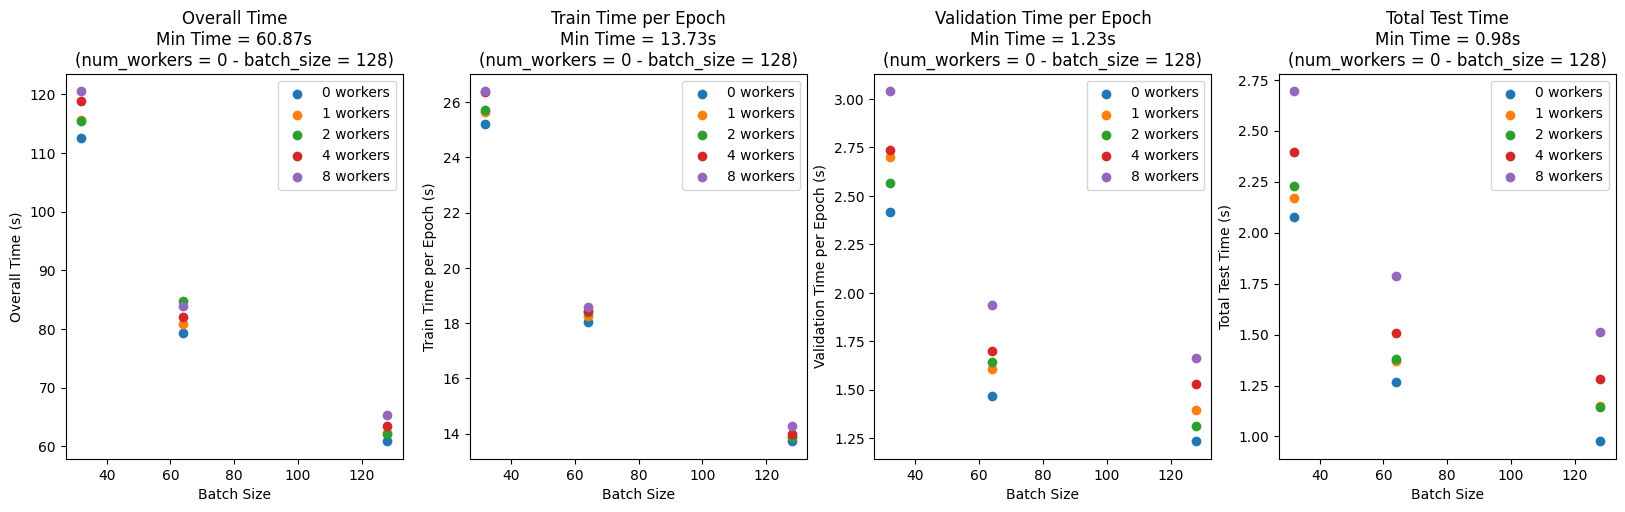

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for num_workers in df["num_workers"].unique():
    axs[0].scatter(df[df["num_workers"] == num_workers]["batch_size"], df[df["num_workers"] == num_workers]["overall_time"], label=f"{num_workers} workers")
axs[0].set_xlabel("Batch Size")
axs[0].set_ylabel("Overall Time (s)")
axs[0].legend()
min_row = df.loc[df["overall_time"].idxmin()]
min_time = min_row["overall_time"]
min_num_workers = min_row["num_workers"]
min_batch_size = min_row["batch_size"]
axs[0].set_title ("Overall Time\nMin Time = "+str(round(min_time,2))+"s\n(num_workers = "+str(round(min_num_workers))+" - batch_size = "+str(round(min_batch_size))+")")


for num_workers in df["num_workers"].unique():
    axs[1].scatter(df[df["num_workers"] == num_workers]["batch_size"], df[df["num_workers"] == num_workers]["train_time_per_epoch"], label=f"{num_workers} workers")
axs[1].set_xlabel("Batch Size")
axs[1].set_ylabel("Train Time per Epoch (s)")
axs[1].legend()
min_row = df.loc[df["train_time_per_epoch"].idxmin()]
min_time = min_row["train_time_per_epoch"]
min_num_workers = min_row["num_workers"]
min_batch_size = min_row["batch_size"]
axs[1].set_title ("Train Time per Epoch\nMin Time = "+str(round(min_time,2))+"s\n(num_workers = "+str(round(min_num_workers))+" - batch_size = "+str(round(min_batch_size))+")")

for num_workers in df["num_workers"].unique():
    axs[2].scatter(df[df["num_workers"] == num_workers]["batch_size"], df[df["num_workers"] == num_workers]["validation_per_epoch"], label=f"{num_workers} workers")
axs[2].set_xlabel("Batch Size")
axs[2].set_ylabel("Validation Time per Epoch (s)")
axs[2].legend()
min_row = df.loc[df["validation_per_epoch"].idxmin()]
min_time = min_row["validation_per_epoch"]
min_num_workers = min_row["num_workers"]
min_batch_size = min_row["batch_size"]
axs[2].set_title ("Validation Time per Epoch\nMin Time = "+str(round(min_time,2))+"s\n(num_workers = "+str(round(min_num_workers))+" - batch_size = "+str(round(min_batch_size))+")")

for num_workers in df["num_workers"].unique():
    axs[3].scatter(df[df["num_workers"] == num_workers]["batch_size"], df[df["num_workers"] == num_workers]["total_test_time"], label=f"{num_workers} workers")
axs[3].set_xlabel("Batch Size")
axs[3].set_ylabel("Total Test Time (s)")
axs[3].legend()
min_row = df.loc[df["total_test_time"].idxmin()]
min_time = min_row["total_test_time"]
min_num_workers = min_row["num_workers"]
min_batch_size = min_row["batch_size"]
axs[3].set_title ("Total Test Time\nMin Time = "+str(round(min_time,2))+"s\n(num_workers = "+str(round(min_num_workers))+" - batch_size = "+str(round(min_batch_size))+")")

plt.show()


*Conclusion: the optimal parameters are num_workers = 0, batch_size = 128.*

## 1. Prepare Dataset

In [ ]:
# read processed data
data = pd.read_csv('Data/imdb_processed.csv')

# get all processed reviews
reviews = data.processed.values
# merge into single variable, separated by whitespaces
words = ' '.join(reviews)
# obtain list of words
words = words.split()

# build vocabulary
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}

# encode words
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

# padding sequences

def pad_features(reviews, pad_id, seq_length=128):
    # features = np.zeros((len(reviews), seq_length), dtype=int)
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)

    for i, row in enumerate(reviews):
        # if seq_length < len(row) then review will be trimmed
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

seq_length = 256
features = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)

assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length

# get labels as numpy
labels = data.label.to_numpy()

100%|██████████| 50000/50000 [00:01<00:00, 26867.83it/s]


## 2. Create sets and loaders

In [ ]:
# train test split
train_size = .7     # we will use 70% of whole data as train set
val_size = .5       # and we will use 50% of test set as validation set

# make train set
split_id = int(len(features) * train_size)
train_x, remain_x = features[:split_id], features[split_id:]
train_y, remain_y = labels[:split_id], labels[split_id:]
# take only half of the examples
train_x = train_x[:train_x.shape[0]//2]
remain_x = remain_x[:remain_x.shape[0]//2]
train_y = train_y[:train_y.shape[0]//2]
remain_y = remain_y[:remain_y.shape[0]//2]

# make val and test set
split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

# print out the shape
print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

print('\nTarget Distribution (#labels = 0, #labels = 1):')
print('===============')
print(len(train_y[train_y == 0]), len(train_y[train_y == 1]))
print(len(val_y[val_y == 0]), len(val_y[val_y == 1]))
print(len(test_y[test_y == 0]), len(test_y[test_y == 1]))

# define batch size
batch_size = 128

# create tensor datasets
trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validset = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# create dataloaders
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size, num_workers=0, pin_memory=True)
valloader = DataLoader(validset, shuffle=True, batch_size=batch_size, num_workers=0, pin_memory=True)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size, num_workers=0, pin_memory=True)

# check our batches
dataiter = iter(trainloader)
x, y = next(dataiter)

print('\nBatches and dataloaders:')
print('===============')
print('Sample batch size: ', x.size())   # batch_size, seq_length
print('Sample batch input: \n', x)
print()
print('Sample label size: ', y.size())   # batch_size
print('Sample label input: \n', y)

# define training device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\ndevice = '+str(device))

Feature Shapes:
Train set: (17500, 256)
Validation set: (3750, 256)
Test set: (3750, 256)

Target Distribution (#labels = 0, #labels = 1):
8863 8637
1864 1886
1889 1861

Batches and dataloaders:
Sample batch size:  torch.Size([128, 256])
Sample batch input: 
 tensor([[  191,   162,   242,  ...,     0,     0,     0],
        [   11,   253,    21,  ...,     0,     0,     0],
        [10382,  7693,     2,  ...,     0,     0,     0],
        ...,
        [ 2114,   606,     2,  ...,     0,     0,     0],
        [    3,  2189,   223,  ...,     0,     0,     0],
        [10458, 26097,  9952,  ...,     0,     0,     0]])

Sample label size:  torch.Size([128])
Sample label input: 
 tensor([1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 

## 3. Modelling

In [ ]:
# model architecture

class SentimentModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2):
        super(SentimentModel, self).__init__()

        # embedding layer is useful to map input into vector representation
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # LSTM layer preserved by PyTorch library
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # Linear layer for output
        self.fc = nn.Linear(hidden_size, output_size)

        # Sigmoid layer cz we will have binary classification
        self.sigmoid = nn.Sigmoid()

        # For quantization
        #self.quant = torch.quantization.QuantStub()
        #self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):

        #x = self.quant(x)
        
        # convert feature to long
        x = x.long()

        # map input to vector
        x = self.embedding(x)

        # pass forward to lstm
        o, _ =  self.lstm(x)

        # get last sequence output
        o = o[:, -1, :]

        # apply dropout and fully connected layer
        o = self.dropout(o)
        o = self.fc(o)

        # sigmoid
        o = self.sigmoid(o)

        #o = self.dequant(o)
        return o

In [ ]:
# model hyperparamters
vocab_size = len(word2int)
output_size = 1
embedding_size = 256
hidden_size = 512
n_layers = 2
dropout=0.25

# model initialization
model = SentimentModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)
# model quantization
#quantization_config = torch.quantization.get_default_qconfig("fbgemm")
#model.qconfig = quantization_config
#torch.quantization.prepare_qat(model, inplace=True)
print(model)

# training config
lr = 0.001
criterion = nn.BCELoss()  # we use BCELoss cz we have binary classification problem
optim = Adam(model.parameters(), lr=lr)
grad_clip = 5
epochs = 1
print_every = 1
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs
}
es_limit = 5

SentimentModel(
  (embedding): Embedding(121301, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## 4. Training and Testing

In [ ]:
# Function that tells us how long segments take
def segment_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def segment_time2(start_time, end_time):
  return end_time - start_time

In [ ]:
profile_training = False
profile_testing = True

train_prof = None
valid_prof = None
test_prof = None
train_secs = 0
valid_secs = 0
test_secs = 0
secs = 0

def run_model(profile_training, profile_testing):

    global train_prof
    global valid_prof
    global test_prof
    global secs

    start_time = time.perf_counter()

    # Training
    if profile_training:
        handler = torch.profiler.tensorboard_trace_handler('Profiling_results/v1_train_results')
        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True, profile_memory=True, on_trace_ready=handler) as train_prof:
            run_train_model()
    else:
        run_train_model()

    # Testing
    if profile_testing:
        handler = torch.profiler.tensorboard_trace_handler('Profiling_results/v1_test_results')
        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True, profile_memory=True, on_trace_ready=handler) as test_prof:
            run_test_model()
    else:
        run_test_model()

    end_time = time.perf_counter()
    secs = segment_time2(start_time, end_time)

def run_train_model():

    global train_secs
    global valid_secs
    global history
    global model
    global optim
    global criterion
    global epochs
    global device
    global trainloader
    global valloader

    # train loop
    model = model.to(device)
    epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

    # early stop trigger
    es_trigger = 0
    val_loss_min = torch.inf

    for e in epochloop:

        #################
        # training mode #
        #################

        train_start_time = time.perf_counter()

        model.train()

        train_loss = 0
        train_acc = 0

        for id, (feature, target) in enumerate(trainloader):
            # add epoch meta info
            epochloop.set_postfix_str(f'Training batch {id}/{len(trainloader)}')

            # move to device
            feature, target = feature.to(device), target.to(device)

            # reset optimizer
            optim.zero_grad()

            # forward pass
            out = model(feature)

            # acc
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            train_acc += acc.item()

            # loss
            loss = criterion(out.squeeze(), target.float())
            train_loss += loss.item()
            loss.backward()

            # clip grad
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            # update optimizer
            optim.step()

            # free some memory
            del feature, target, predicted

            history['train_loss'].append(train_loss / len(trainloader))
            history['train_acc'].append(train_acc / len(trainloader))

        train_end_time = time.perf_counter()
        train_secs += segment_time2(train_start_time, train_end_time)

        valid_start_time = time.perf_counter()

        ####################
        # validation mode  #
        ####################

        # For quantization
        #model = torch.quantization.convert(model, inplace=True)
        model.eval()

        val_loss = 0
        val_acc = 0

        with torch.no_grad():
            for id, (feature, target) in enumerate(valloader):
                # add epoch meta info
                epochloop.set_postfix_str(f'Validation batch {id}/{len(valloader)}')
                  
                # move to device
                feature, target = feature.to(device), target.to(device)

                # forward pass
                out = model(feature)

                # acc
                predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
                equals = predicted == target
                acc = torch.mean(equals.type(torch.FloatTensor))
                val_acc += acc.item()

                # loss
                loss = criterion(out.squeeze(), target.float())
                val_loss += loss.item()

                # free some memory
                del feature, target, predicted

            history['val_loss'].append(val_loss / len(valloader))
            history['val_acc'].append(val_acc / len(valloader))

        # reset model mode
        model.train()

        # add epoch meta info
        epochloop.set_postfix_str(f'Val Loss: {val_loss / len(valloader):.3f} | Val Acc: {val_acc / len(valloader):.3f}')

        # print epoch
        if (e+1) % print_every == 0:
              epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(trainloader):.3f} Train Acc: {train_acc / len(trainloader):.3f} | Val Loss: {val_loss / len(valloader):.3f} Val Acc: {val_acc / len(valloader):.3f}')
              epochloop.update()

        # save model if validation loss decrease
        if val_loss / len(valloader) <= val_loss_min:
              torch.save(model.state_dict(), 'Checkpoints/v1_sentiment_lstm.pt')
              val_loss_min = val_loss / len(valloader)
              es_trigger = 0
        else:
              epochloop.write(f'[WARNING] Validation loss did not improved ({val_loss_min:.3f} --> {val_loss / len(valloader):.3f})')
              es_trigger += 1

        # force early stop
        if es_trigger >= es_limit:
            epochloop.write(f'Early stopped at Epoch-{e+1}')
            # update epochs history
            history['epochs'] = e+1
            #break

        valid_end_time = time.perf_counter()
        valid_secs += segment_time2(valid_start_time, valid_end_time)

def run_test_model():

    global test_secs
    global history
    global model
    global optim
    global criterion
    global epochs
    global device
    global testloader

    test_start_time = time.perf_counter()

    # test loop
    #################
    #   test mode   #
    #################

    #with record_function("test_eval_func"):
    model.eval()

    # metrics
    test_loss = 0
    test_acc = 0

    all_target = []
    all_predicted = []

    testloop = tqdm(testloader, leave=True, desc='Inference')
    with torch.no_grad():
        for feature, target in testloop:

            #with record_function("test_move_to_device"):
            feature, target = feature.to(device), target.to(device)

            #with record_function("test_forward_pass"):
            out = model(feature)
            
            with record_function("test_accuracy"):
                predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
                equals = predicted == target
                acc = torch.mean(equals.type(torch.FloatTensor))
                test_acc += acc.item()

            with record_function("test_loss"):
                loss = criterion(out.squeeze(), target.float())
                test_loss += loss.item()

            all_target.extend(target.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

        print(f'Accuracy: {test_acc/len(testloader):.4f}, Loss: {test_loss/len(testloader):.4f}')

    test_end_time = time.perf_counter()
    test_secs = segment_time2(test_start_time, test_end_time)

In [ ]:
run_model(profile_training, profile_testing)

Training: 100%|██████████| 1/1 [00:33<00:00, 33.01s/it, Val Loss: 0.693 | Val Acc: 0.501]

Epoch 1/1 | Train Loss: 0.694 Train Acc: 0.501 | Val Loss: 0.693 Val Acc: 0.501


Inference: 100%|██████████| 30/30 [00:02<00:00, 12.73it/s]


Accuracy: 0.4922, Loss: 0.6936


## 5. Visualize profiling results

In [ ]:
print('\nTime:')
print('===============')
print(f'Overall Time: {secs}s')
print(f'\tTotal train Time: {train_secs}s')
print(f'\tTotal validation Time: {valid_secs}s')
print(f'\tTotal test Time: {test_secs}s')
print(f'\tTrain Time per epoch: {train_secs/epochs}s')
print(f'\tValidation per epoch: {valid_secs/epochs}s')

if train_prof:
    print(train_prof.key_averages())
    print(train_prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=10))
    print(train_prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))
    print(train_prof.key_averages().table(sort_by="cuda_memory_usage", row_limit=10))
    print(train_prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

if test_prof:
    print(test_prof.key_averages())
    print(test_prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=10))
    print(test_prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))
    print(test_prof.key_averages().table(sort_by="cuda_memory_usage", row_limit=10))
    print(test_prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))


Time:
Overall Time: 54.07046911300006s
	Total train Time: 30.684167674000037s
	Total validation Time: 2.6935359039999867s
	Total test Time: 2.3633832189999566s
	Train Time per epoch: 30.684167674000037s
	Validation per epoch: 2.6935359039999867s
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ----

In [ ]:
# %cd '/content/drive/MyDrive/HPML/Project/2. LSTM/Profiling_results/'

# import locale
# def getpreferredencoding(do_setlocale = True):
#     return "UTF-8"
# locale.getpreferredencoding = getpreferredencoding
# !pip install tensorboardX
# !pip install torch-tb-profiler

# %load_ext tensorboard
# if train_prof:
#   %tensorboard --logdir v1_train_results
# elif test_prof:
#   %tensorboard --logdir v1_test_results